In [1]:
import sys
sys.path.append("../../dataprocessing")
import numpy as np
import os
import PIL
import PIL.Image
from PIL import ImageDraw
import tensorflow as tf
# import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm
import random
import data_process
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.spatial import distance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

## 함수 정의

In [2]:
cd ../

c:\Users\jongm\Desktop\MINI\projects\Facial-Expression-Recognition\modeling


In [3]:
def cal_dist(data):
    landmark_matrixs, landmark_matrixs_df = [], []
    lp = [point[:-1] for point in data.columns if '-' in point]
    set_lp = sorted(set(lp), key = lambda x: lp.index(x))
    for idx, row in data.iterrows():
        # print(str(idx)+" 하는중")
        temp_list = []
        for i in range(len(set_lp)):
            temp_list.append([row[set_lp[i]+'x'], row[set_lp[i]+'y']])
        temp = pd.DataFrame(distance.cdist(temp_list, temp_list, metric='euclidean'), index=set_lp, columns=set_lp)
        landmark_matrixs.append(temp)
        landmark_matrixs_df.append(temp.to_numpy()[np.triu_indices(len(set_lp), 1)])
    return landmark_matrixs, pd.DataFrame(landmark_matrixs_df)

In [4]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        # if data.columns[idx] == 'frame':
        #     continue
        if data.columns[idx][:-1] in target_landmark:
            # print(x,y)
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        else:
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [5]:
def show_diff(*args):
    data = args[0]
    window = args[1]
    erase_list = ['frame','left','top','right','bottom','time_diff']
    data3 = data[[point for point in data.columns if '-' in point] + erase_list]

    if len(args) == 3:
        idxs = args[2]
        i = 0
        for idx in idxs:
            if i == 0:
                data2 = data[[point for point in data.columns if str(idx) == point.split('-')[0]]]
            else:
                data2 = pd.concat([data2, data[[point for point in data.columns if str(idx) == point.split('-')[0]]]], axis=1)
            i += 1
        data2 = pd.concat([data2, data[erase_list]], axis=1)
        # print(data2.columns)
    else:
        data2 = data3.copy()

    # print(list(set(data.columns) - set(erase_list)))
    remain_list = sorted(list(set(data2.columns) - set(erase_list)))
    diff_df = pd.DataFrame(columns=list(range(len(data2))), index=list(set([c[:-1] for c in remain_list])))

    # print(data2, remain_list)    
    for row in range(0, len(remain_list), 2):
        init_point = [data2.iloc[0][remain_list[row]], data2.iloc[0][remain_list[row+1]]]
        # print(remain_list[col], remain_list[col+1])
        temp2 = 0.0
        # diff_df[remain_list[col][:-1]] = 0
        for col in range(len(data2)):    
            # print(init_point, data.loc[col][remain_list[row]], data.loc[col][remain_list[row+1]])    
            temp = distance.euclidean(init_point, [data2.loc[col][remain_list[row]], data2.loc[col][remain_list[row+1]]])
            temp2 += temp
            # for start in range(0,len(data.index), window):
            #     # print(max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col]), max(data.iloc[start:start+5][col]), min(data.iloc[start:start+5][col]))
            #     temp += max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col])
            diff_df.at[remain_list[row][:-1], col] = temp
        diff_df.at[remain_list[row][:-1], 'sum'] = temp2
        # print(remain_list[col] + ", "+ remain_list[col+1])
    return diff_df.sort_values('sum', ascending=False), data3

In [6]:
def make_flow_chart(data, diff_df, part, order, image_order, path):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (20,10))
    # sort = diff_df.iloc[:order]
    diff_df = diff_df.drop(['sum'], axis=1)
    # print(diff_df)
    new_data = diff_df.iloc[:order]
    print(new_data.index)
    # new_data = new_data[[point for point in new_data.columns if str(part) == point.split('-')[0]]]
    temp_plot = sns.lineplot(data = new_data.transpose(), markers=False, dashes=False)  
    # print(path+str(image_order) + '.0.jpg')
    show_img(data, path + str(image_order) + '.0.jpg', new_data)
    # ax[idx, col].set_title(str(idx) +" 번 클러스터")
    # if col==0:        
    #     ax[idx, col].set_ylabel(list(custom_sort.keys())[idx])
    #     ax[idx, col].yaxis.label.set_size(20)
    # ax[idx].set_ylabel(list(custom_sort.keys())[idx] + " group")
    # ax[idx].set_xticks(list(range(1,len(seq)+1)))        
    # for row in data.iterrows():
    #     ax[idx].text(row[0], int(row[1]['quiz']), int(row[1]['quiz']), fontsize=12, ha='center') 
    #     ax[idx].text(row[0], int(row[1]['proj']), int(row[1]['proj']), fontsize=12, ha='center')

> 0은 얼굴 테두리 \
> 1, 2는 왼쪽 눈썹 위, 아래 \
> 3, 4는 오른쪽 눈썹 위, 아래 \
> 5, 6은 왼쪽, 오른쪽 눈 \
> 7, 8은 위쪽 입술 윗부분, 아래부분 \
> 9, 10은 아래쪽 입술 윗부분, 아래부분 \
> 11은 코 세로축 \
> 12는 코 아래부분

## 1. 눈썹 들어올리기

In [11]:
landmarks = pd.read_csv('../data/images/눈썹들어올리기/202208.23123145716.csv')

In [37]:
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs[0]

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,10-6,10-7,10-8,11-0,11-1,12-0,12-1,12-2,13-0,14-0
0-0,0.000000,17.000000,48.259714,70.213959,86.330759,102.415819,113.991228,127.561750,142.270868,157.200509,...,197.820626,194.612435,191.366141,70.000000,137.000000,148.946299,148.000000,148.124947,150.986754,152.643375
0-1,17.000000,0.000000,31.400637,53.600373,70.384657,87.464278,100.264650,115.312619,131.400152,147.665162,...,200.084982,197.517088,194.756258,72.034714,138.050715,152.610616,148.973152,146.219014,157.867033,147.258277
0-2,48.259714,31.400637,0.000000,22.472205,40.496913,59.464275,74.652528,92.439169,110.923397,129.448832,...,203.027092,201.675482,199.849944,80.802228,140.456399,159.210552,150.840976,142.863571,170.000000,137.233378
0-3,70.213959,53.600373,22.472205,0.000000,19.104973,39.408121,56.356011,75.960516,95.880134,115.732450,...,203.531324,203.066492,201.933157,89.498603,141.904898,163.110392,151.611345,140.089257,177.519013,129.653384
0-4,86.330759,70.384657,40.496913,19.104973,0.000000,20.591260,38.275318,58.694122,79.246451,99.724621,...,197.230829,197.496835,196.946693,92.590496,137.200583,160.112460,146.167712,131.946959,177.459855,117.902502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-0,148.946299,152.610616,159.210552,163.110392,160.112460,154.466825,145.660564,135.532284,127.137721,119.854078,...,50.358713,46.010868,42.426407,80.653580,26.000000,0.000000,24.020824,49.010203,30.594117,80.156098
12-1,148.000000,148.973152,150.840976,151.611345,146.167712,138.105032,127.475488,115.377641,105.190304,96.540147,...,52.201533,51.478151,50.803543,78.000000,11.000000,24.020824,0.000000,25.079872,54.451814,56.320511
12-2,148.124947,146.219014,142.863571,140.089257,131.946959,121.202310,108.577162,94.260278,81.987804,71.840100,...,66.708320,68.622154,69.814039,80.006250,26.570661,49.010203,25.079872,0.000000,79.158070,31.256999
13-0,150.986754,157.867033,170.000000,177.519013,177.459855,174.734084,168.181450,160.464949,154.259522,148.758193,...,66.573268,59.539903,53.665631,89.202018,54.147945,30.594117,54.451814,79.158070,0.000000,110.004545


Index(['0-6', '0-5', '0-4', '0-7', '0-2', '0-3', '3-0', '4-0', '0-0', '3-1'], dtype='object')


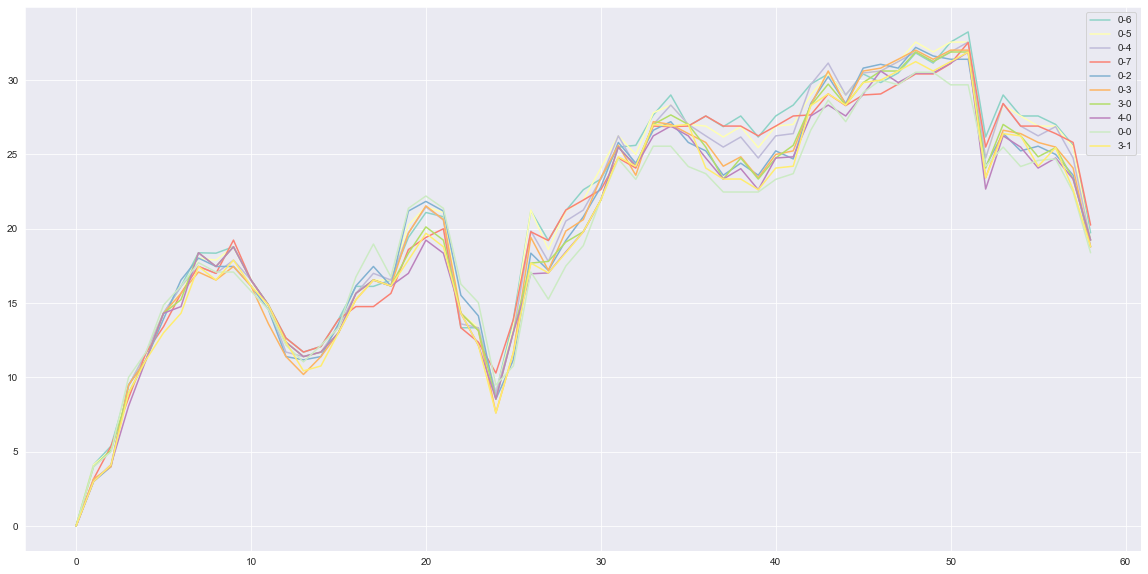

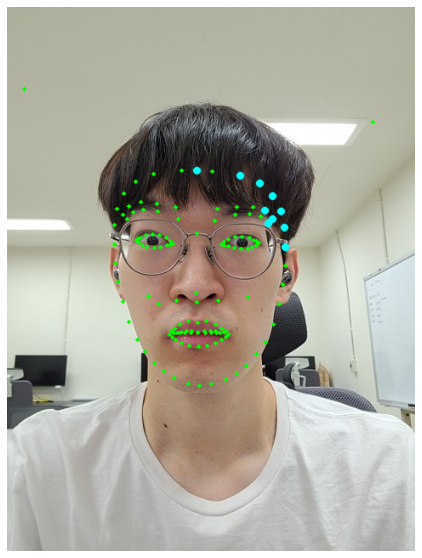

In [5]:
landmarks = pd.read_csv('../data/images/눈썹들어올리기/202208.23123145716.csv')
diff_list, landmarks_cut = show_diff(landmarks, 5)
make_flow_chart(part= 1, order = 10, image_order = 20, path= '../data/images/눈썹들어올리기/', data = landmarks_cut, diff_df= diff_list)

Index(['3-0', '4-0', '3-1', '3-2', '4-1', '4-2', '3-3', '4-3', '3-4', '4-4',
       '2-4', '1-3', '2-3', '2-0', '1-2', '1-4', '2-2', '1-1', '2-1', '1-0'],
      dtype='object')


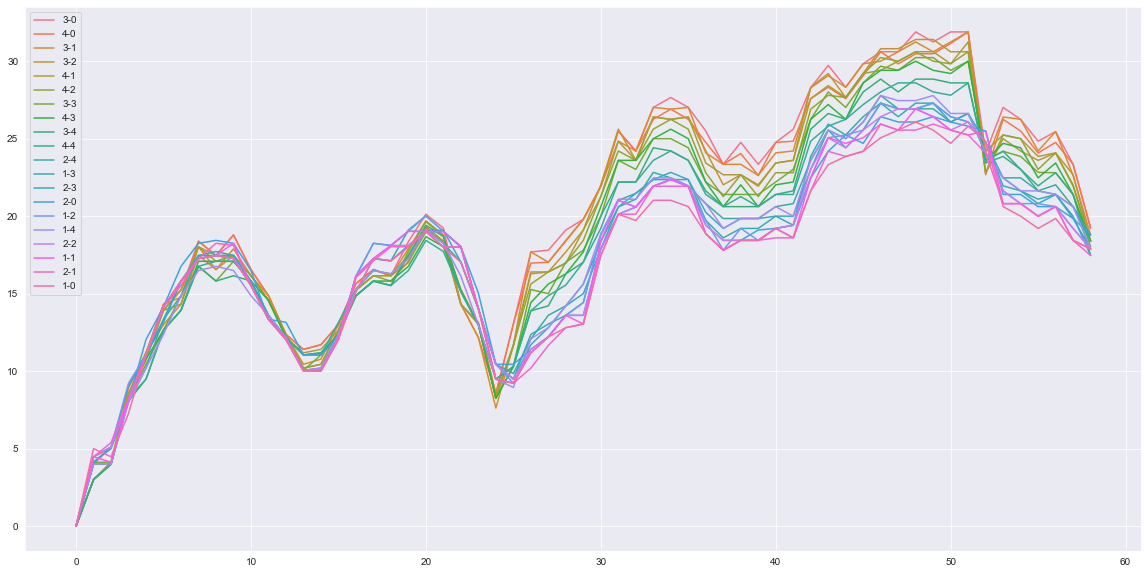

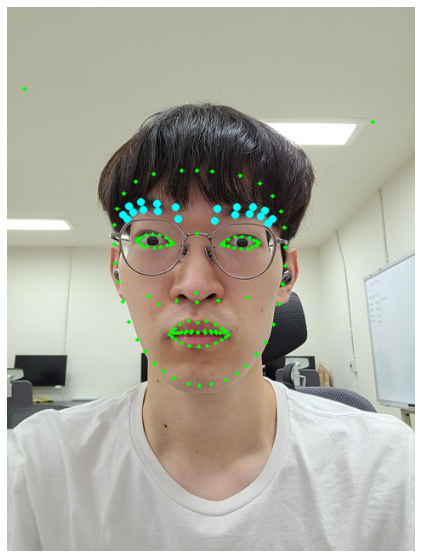

In [57]:
landmarks = pd.read_csv('../data/images/눈썹들어올리기/202208.23123145716.csv')
diff_list, landmarks_cut = show_diff(landmarks, 5, [1,2,3,4])
make_flow_chart(part= 1, order = 20, image_order = 20, path= '../data/images/눈썹들어올리기/', data = landmarks_cut, diff_df= diff_list)

## 3. 두 눈 감기

In [9]:
landmarks = pd.read_csv('../data/images/202209.03105902855+0/202209.03105902855.csv')
landmarks2 = pd.read_csv('../data/images/202209.03105914019+1/202209.03105914019.csv')
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [24]:
landmark_matrixs[0]

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,10-6,10-7,10-8,11-0,11-1,12-0,12-1,12-2,13-0,14-0
0-0,0.000000,20.000000,56.142675,82.036577,101.242284,119.507322,132.400906,148.394744,164.830216,181.207064,...,224.501670,221.199005,217.807254,86.005814,165.003030,174.522205,176.011363,175.251248,177.730133,178.639301
0-1,20.000000,0.000000,36.221541,62.369865,82.280010,101.597244,115.801554,133.645052,151.818971,169.811660,...,226.717886,224.162887,221.269067,88.073833,166.330995,178.263849,176.918060,173.184872,185.224188,172.255624
0-2,56.142675,36.221541,0.000000,26.570661,48.020829,69.526973,86.452299,107.912001,129.247824,150.053324,...,231.173095,229.993478,228.035085,98.737024,170.792271,186.552942,180.277564,171.303824,199.729818,162.308349
0-3,82.036577,62.369865,26.570661,0.000000,22.627417,45.607017,64.498062,88.391176,111.682586,134.171532,...,231.812424,231.657074,230.412673,108.300508,172.707846,190.829767,181.135309,168.549696,208.197022,153.733536
0-4,101.242284,82.280010,48.020829,22.627417,0.000000,23.323808,43.081318,68.154237,92.395887,115.732450,...,224.875521,225.568172,224.931101,111.646764,167.630546,187.445992,175.025712,159.677801,208.197022,140.463518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-0,174.522205,178.263849,186.552942,190.829767,187.445992,181.107703,171.207476,157.648343,145.962324,136.124943,...,51.623638,47.000000,43.289722,90.249654,23.409400,0.000000,25.179357,51.000000,35.355339,89.274856
12-1,176.011363,176.918060,180.277564,181.135309,175.025712,166.066252,154.175225,138.220838,124.326184,112.641023,...,50.921508,50.606324,50.000000,90.005555,11.401754,25.179357,0.000000,26.172505,60.530984,64.776539
12-2,175.251248,173.184872,171.303824,168.549696,159.677801,148.111445,134.316790,116.103402,100.169856,86.977008,...,66.708320,69.354164,70.604532,91.093359,30.083218,51.000000,26.172505,0.000000,86.145226,38.639358
13-0,177.730133,185.224188,199.729818,208.197022,208.197022,205.060967,197.590486,186.850207,177.609121,169.705627,...,70.604532,62.681736,56.603887,101.019800,57.078893,35.355339,60.530984,86.145226,0.000000,124.016128


In [32]:
np.triu_indices(133)

(array([  0,   0,   0, ..., 131, 131, 132]),
 array([  0,   1,   2, ..., 131, 132, 132]))

In [36]:
landmark_matrixs[0].iloc[np.triu_indices(133)]

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,12-1,12-2,13-0,14-0,12-2,13-0,14-0,13-0,14-0,14-0
0-0,0.000000,20.000000,56.142675,82.036577,101.242284,119.507322,132.400906,148.394744,164.830216,181.207064,...,176.011363,175.251248,177.730133,178.639301,175.251248,177.730133,178.639301,177.730133,178.639301,178.639301
0-0,0.000000,20.000000,56.142675,82.036577,101.242284,119.507322,132.400906,148.394744,164.830216,181.207064,...,176.011363,175.251248,177.730133,178.639301,175.251248,177.730133,178.639301,177.730133,178.639301,178.639301
0-0,0.000000,20.000000,56.142675,82.036577,101.242284,119.507322,132.400906,148.394744,164.830216,181.207064,...,176.011363,175.251248,177.730133,178.639301,175.251248,177.730133,178.639301,177.730133,178.639301,178.639301
0-0,0.000000,20.000000,56.142675,82.036577,101.242284,119.507322,132.400906,148.394744,164.830216,181.207064,...,176.011363,175.251248,177.730133,178.639301,175.251248,177.730133,178.639301,177.730133,178.639301,178.639301
0-0,0.000000,20.000000,56.142675,82.036577,101.242284,119.507322,132.400906,148.394744,164.830216,181.207064,...,176.011363,175.251248,177.730133,178.639301,175.251248,177.730133,178.639301,177.730133,178.639301,178.639301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-2,175.251248,173.184872,171.303824,168.549696,159.677801,148.111445,134.316790,116.103402,100.169856,86.977008,...,26.172505,0.000000,86.145226,38.639358,0.000000,86.145226,38.639358,86.145226,38.639358,38.639358
12-2,175.251248,173.184872,171.303824,168.549696,159.677801,148.111445,134.316790,116.103402,100.169856,86.977008,...,26.172505,0.000000,86.145226,38.639358,0.000000,86.145226,38.639358,86.145226,38.639358,38.639358
13-0,177.730133,185.224188,199.729818,208.197022,208.197022,205.060967,197.590486,186.850207,177.609121,169.705627,...,60.530984,86.145226,0.000000,124.016128,86.145226,0.000000,124.016128,0.000000,124.016128,124.016128
13-0,177.730133,185.224188,199.729818,208.197022,208.197022,205.060967,197.590486,186.850207,177.609121,169.705627,...,60.530984,86.145226,0.000000,124.016128,86.145226,0.000000,124.016128,0.000000,124.016128,124.016128


### rf

[[13  0]
 [ 0 12]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000


<AxesSubplot:xlabel='importance', ylabel='landmarks'>

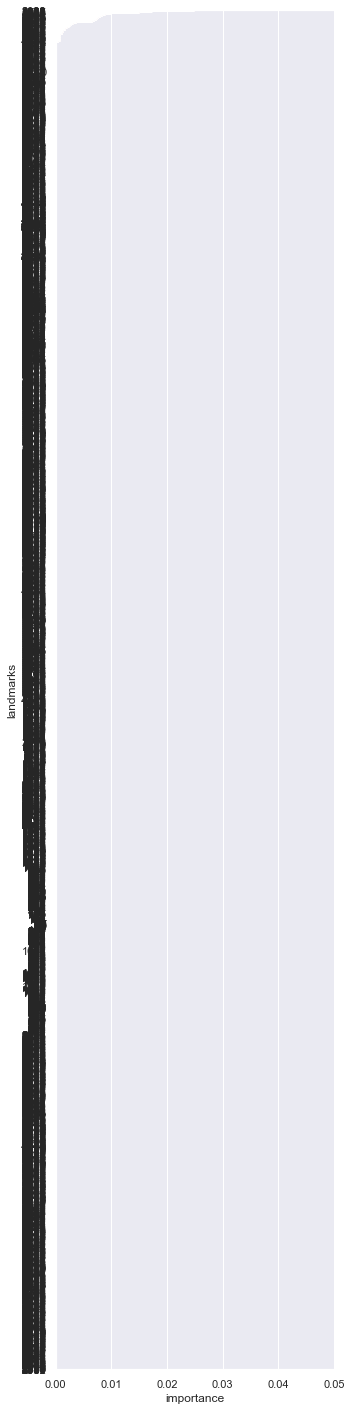

In [41]:
rand_clf = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=2022, oob_score=True)

rand_clf.fit(X_train, y_train)
pred = rand_clf.predict(X_test)
print(confusion_matrix(y_test, pred))
# accuracy = accuracy_score(y_test, pred)
# print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))
print('훈련세트 정확도: {:.3f}' .format(rand_clf.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rand_clf.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': X.columns, 'importance': rand_clf.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
sns.set(rc = {'figure.figsize':(5,25)})
sns.barplot(x=importance.importance , y=importance.landmarks)

### xgboost

[[13  0]
 [ 0 12]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000


<AxesSubplot:xlabel='importance', ylabel='landmarks'>

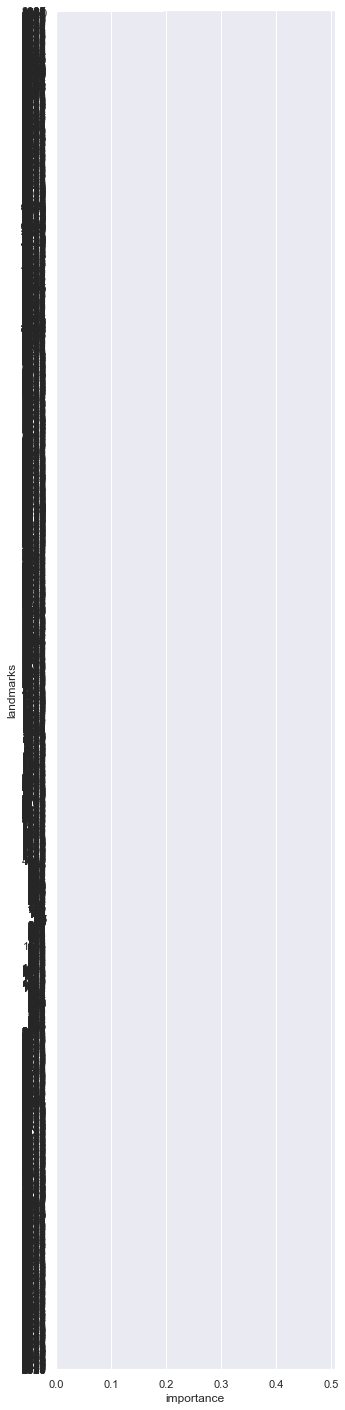

In [42]:
model = XGBClassifier(use_label_encoder=False,
                        eval_metric='mlogloss')
hist = model.fit(X_train, y_train)
pred = rand_clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print('훈련세트 정확도: {:.3f}' .format(model.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(model.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': X_train.columns, 'importance': model.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
sns.set(rc = {'figure.figsize':(5,25)})
sns.barplot(x=importance.importance , y=importance.landmarks)

## 4. 두 눈 크게 뜨기

Index(['3-2', '3-3', '4-2', '1-3', '4-1', '3-4', '1-4', '4-3', '3-1', '0-2'], dtype='object')


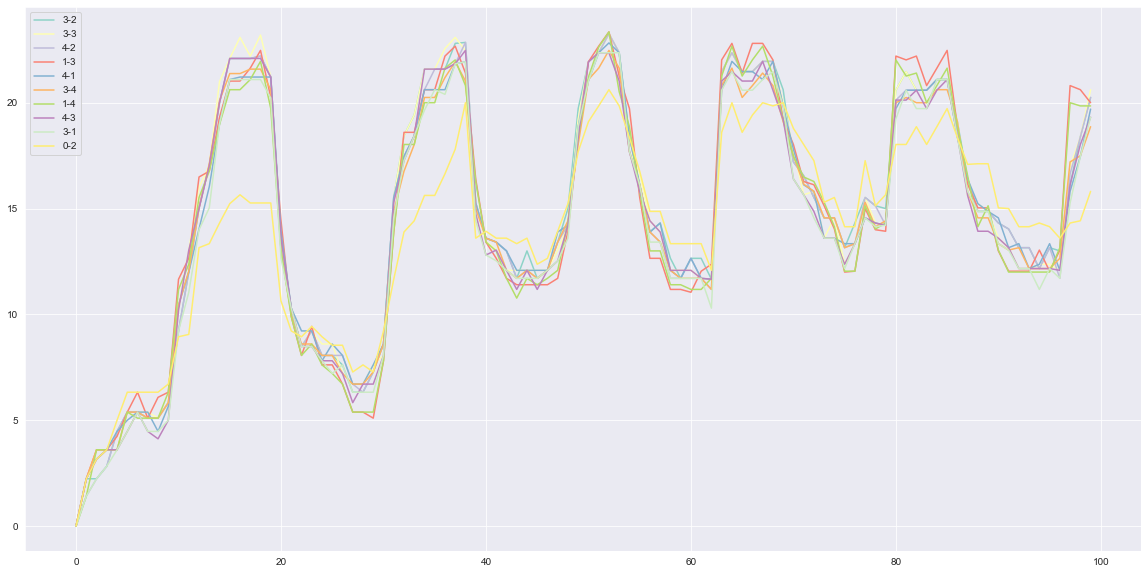

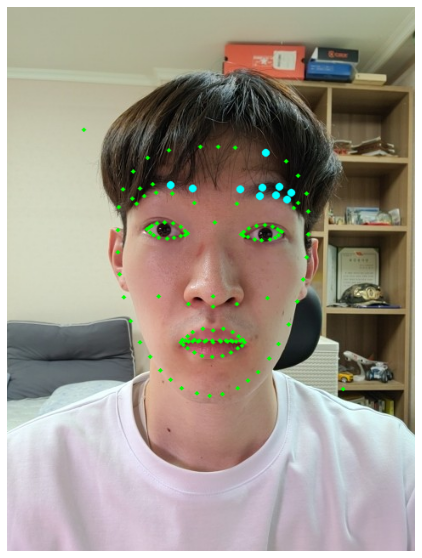

In [228]:
face = '두눈크게뜨기'
landmarks = pd.read_csv('../data/images/'+face+'/202208.20172106650.csv')
landmarks_cut = landmarks[['frame'] + [point for point in landmarks.columns if '-' in point] + ['left','top','right','bottom']]
diff_list = show_diff(landmarks_cut, 5)
make_flow_chart(part= 1, order = 10, image_order = 7,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 9. 입벌리기

Index(['11-1', '12-1', '7-4', '12-2', '7-6', '4-3', '7-3', '12-0', '3-4',
       '7-5'],
      dtype='object')


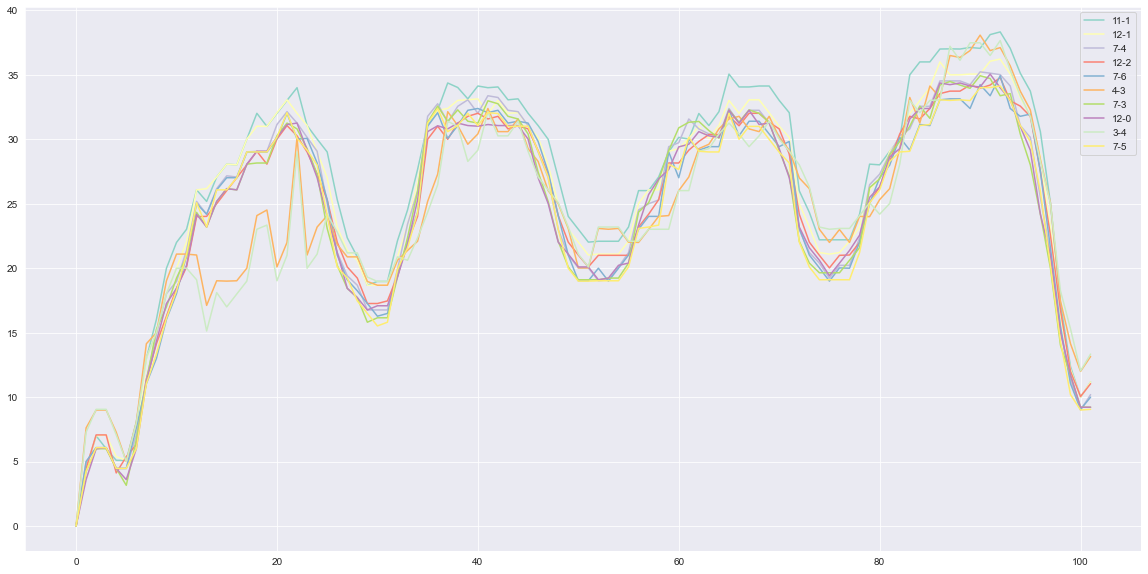

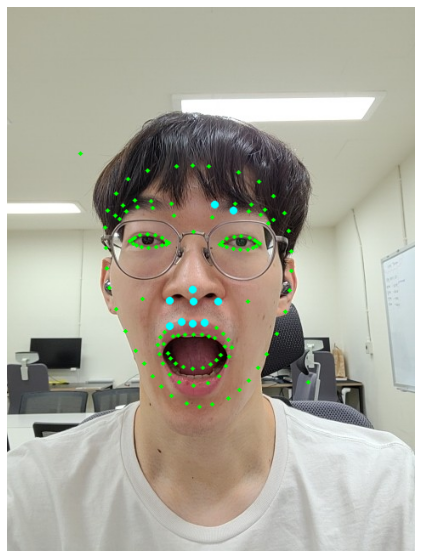

In [227]:
face = '입벌리기'
landmarks = pd.read_csv('../data/images/'+face+'/202208.23122709306.csv')
landmarks_cut = landmarks[['frame'] + [point for point in landmarks.columns if '-' in point] + ['left','top','right','bottom']]
diff_list = show_diff(landmarks_cut, 5)
make_flow_chart(part= 1, order = 10, image_order = 8,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

> 입 크게 벌리니까 landmark 인식을 제대로 못함

## 10. 입술 오므리기

In [207]:
diff_list

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,sum
11-1,0.0,4.472136,7.0,6.0,5.09902,5.09902,8.062258,13.0,16.03122,20.0,...,37.054015,35.128336,33.734256,30.594117,25.079872,17.262677,12.369317,10.0,11.18034,2717.354554
12-1,0.0,4.472136,7.0,7.071068,5.385165,5.09902,7.071068,13.0,15.033296,18.027756,...,35.057096,33.24154,31.780497,28.635642,23.194827,16.278821,12.165525,10.0,11.18034,2618.090733
7-4,0.0,5.0,6.082763,6.082763,4.472136,4.472136,7.071068,11.401754,14.866069,18.027756,...,34.132096,31.064449,30.149627,25.495098,21.095023,15.132746,11.401754,9.0,10.198039,2529.596296
12-2,0.0,4.472136,7.071068,7.071068,4.123106,5.385165,6.324555,11.401754,14.142136,16.278821,...,32.984845,32.572995,31.780497,27.513633,22.561028,16.763055,12.0,10.049876,11.045361,2506.619874
7-6,0.0,5.0,6.082763,6.082763,4.472136,4.472136,7.615773,11.045361,13.0,16.03122,...,32.388269,31.780497,31.953091,27.513633,21.587033,15.524175,11.045361,9.055385,10.0,2478.467240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-5,0.0,4.472136,5.0,6.0,3.605551,1.0,20.024984,19.416488,22.803509,21.84033,...,4.472136,10.049876,6.403124,13.0,17.117243,13.152946,11.401754,9.055385,9.219544,1223.090920
9-6,0.0,4.242641,5.09902,5.0,2.828427,2.236068,18.027756,17.464249,20.248457,19.313208,...,5.09902,6.324555,2.828427,12.649111,17.117243,13.038405,11.401754,8.062258,8.246211,1215.924307
9-3,0.0,4.242641,5.09902,6.082763,4.242641,2.236068,20.223748,20.024984,23.0,22.022716,...,6.403124,12.806248,13.0,15.620499,17.720045,13.601471,11.045361,8.062258,9.0,1197.440073
10-4,0.0,3.605551,4.123106,5.0,2.828427,4.123106,24.020824,23.021729,26.172505,25.179357,...,5.0,13.601471,12.041595,10.630146,15.297059,12.165525,11.18034,8.0,7.071068,1167.237352


In [242]:
landmarks

,frame,top,bottom,left,right,0-0x,0-0y,0-1x,0-1y,0-2x,...,6y,7x,7y,9x,9y,10x,10y,11x,11y,time_diff
0,0.0,220.0,481.0,97.0,353.0,219.0,252.0,236.0,253.0,268.0,...,378.885010,289.520203,392.618897,327.125214,363.726410,270.316132,325.566650,261.609314,434.875397,0
1,1.0,219.0,475.0,97.0,353.0,219.0,244.0,237.0,245.0,268.0,...,372.286285,291.716644,386.177429,328.763428,354.727966,272.242493,319.161743,261.578125,428.263031,80
2,2.0,223.0,475.0,101.0,353.0,220.0,244.0,238.0,244.0,269.0,...,371.950317,293.183441,384.722870,328.504730,356.808014,273.555298,317.862335,262.780090,427.921417,79
3,3.0,223.0,475.0,101.0,353.0,220.0,244.0,238.0,244.0,269.0,...,371.790680,292.513794,384.851196,329.487030,353.063751,273.990540,317.715118,261.537720,428.125702,81
4,4.0,220.0,476.0,99.0,356.0,221.0,244.0,238.0,244.0,270.0,...,373.299194,293.089142,386.152710,330.020019,358.241394,273.886780,319.359894,262.778381,429.576599,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,173.0,210.0,470.0,92.0,353.0,220.0,234.0,238.0,235.0,269.0,...,365.096954,290.628540,380.918060,326.376434,347.494568,271.788361,312.500610,258.779999,423.001068,86
174,174.0,210.0,470.0,92.0,353.0,221.0,233.0,239.0,234.0,270.0,...,366.019318,290.850067,381.853882,326.399872,348.981018,272.165680,313.381683,260.891449,422.448975,78
175,175.0,210.0,470.0,92.0,353.0,221.0,233.0,239.0,234.0,270.0,...,365.930389,292.166809,380.488464,327.570587,346.988556,272.151459,312.039551,263.802765,422.239044,84
176,176.0,212.0,468.0,92.0,348.0,218.0,233.0,236.0,234.0,267.0,...,368.024506,287.134644,382.662445,321.633392,347.612793,267.342651,314.049377,260.656433,423.907074,85


Index(['0-30', '0-29', '0-31', '0-27', '0-32', '0-28', '0-33', '0-25', '1-0',
       '0-26'],
      dtype='object')


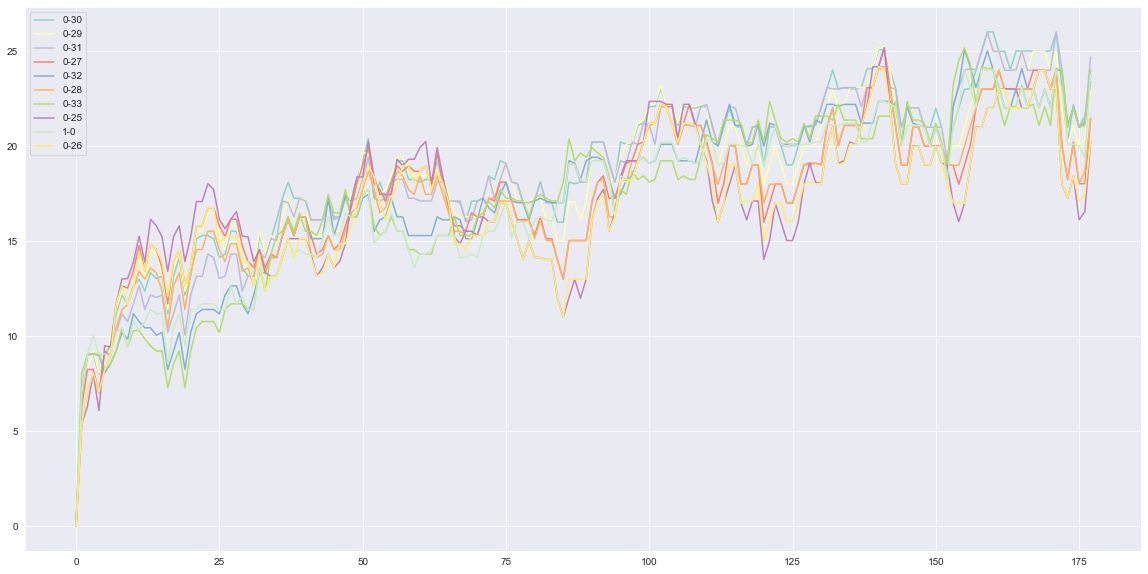

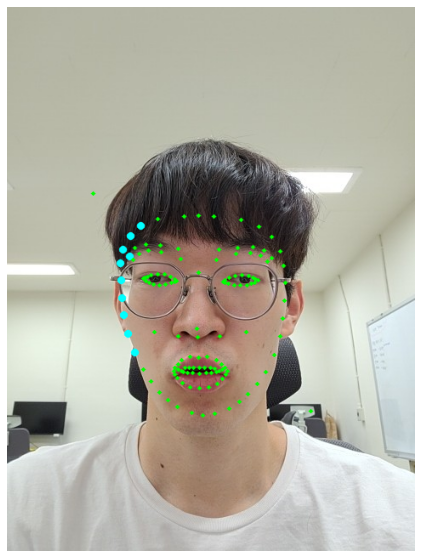

In [241]:
face = '입술오므리기2'
landmarks = pd.read_csv('../data/images/'+face+'/202208.23143251488.csv')
landmarks = landmarks.dropna()
landmarks_cut = landmarks[['frame'] + [point for point in landmarks.columns if '-' in point] + ['left','top','right','bottom']]
diff_list = show_diff(landmarks_cut, 5)
make_flow_chart(part= 1, order = 10, image_order = 10,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 16. 미소짓기

Index(['7-1', '7-0', '7-2', '8-0', '8-1', '8-2', '7-9', '10-8', '7-10', '7-3'], dtype='object')


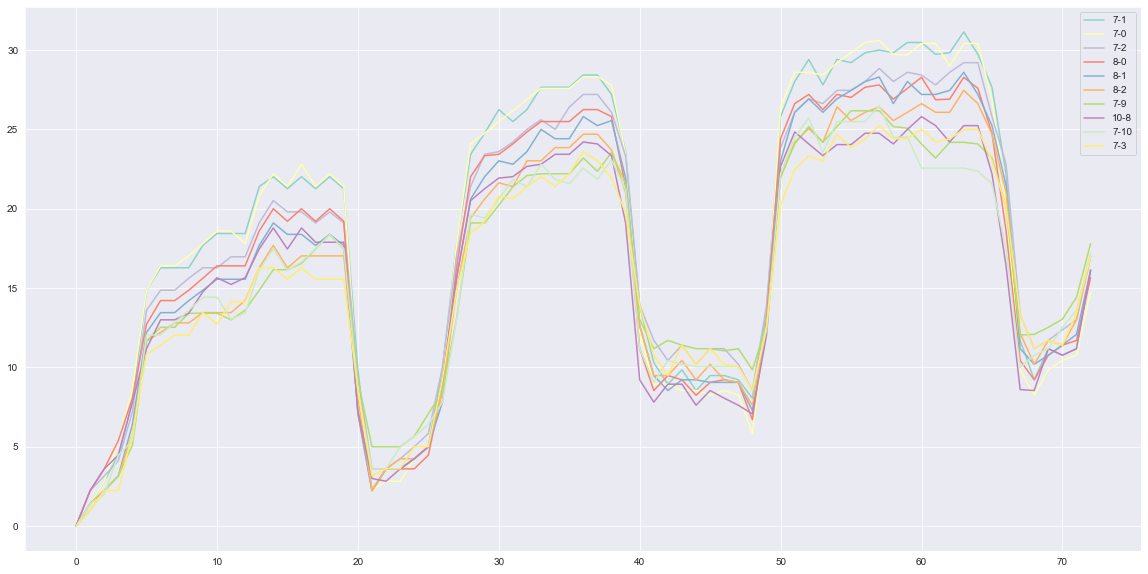

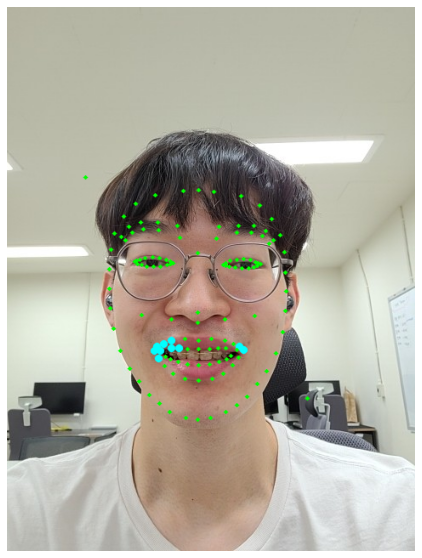

In [232]:
face = '미소짓기'
landmarks = pd.read_csv('../data/images/'+face+'/202208.23122804433.csv')
landmarks_cut = landmarks[['frame'] + [point for point in landmarks.columns if '-' in point] + ['left','top','right','bottom']]
diff_list = show_diff(landmarks_cut, 5)
make_flow_chart(part= 1, order = 10, image_order = 13,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)